In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization,GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# !pip install tensorflow==2.16.1
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
import os
os.environ['KAGGLE_USERNAME']="mqasimali"
os.environ['KAGGLE_KEY']="03318089e106031ba1a9847ff6f1fd25"
!kaggle datasets download sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 97% 84.0M/86.8M [00:01<00:00, 64.2MB/s]
100% 86.8M/86.8M [00:01<00:00, 54.0MB/s]


In [4]:
!unzip /content/brain-tumor-classification-mri

Archive:  /content/brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg

In [5]:
dataset_path = '/content/Training'

image_paths = []
labels = []

for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, filename))
            labels.append(label)

data = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(data.head())

print(data['label'].value_counts())

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

                                        image_path             label
0  /content/Training/meningioma_tumor/m3 (147).jpg  meningioma_tumor
1  /content/Training/meningioma_tumor/m2 (108).jpg  meningioma_tumor
2  /content/Training/meningioma_tumor/m3 (178).jpg  meningioma_tumor
3  /content/Training/meningioma_tumor/m2 (125).jpg  meningioma_tumor
4     /content/Training/meningioma_tumor/m1(7).jpg  meningioma_tumor
label
pituitary_tumor     827
glioma_tumor        826
meningioma_tumor    822
no_tumor            395
Name: count, dtype: int64
Training set size: 2296
Testing set size: 574


In [6]:
from tqdm import tqdm
X_train = []
y_train = []

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 150
for i in labels:
    folderPath = os.path.join('/content/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 199.35it/s]


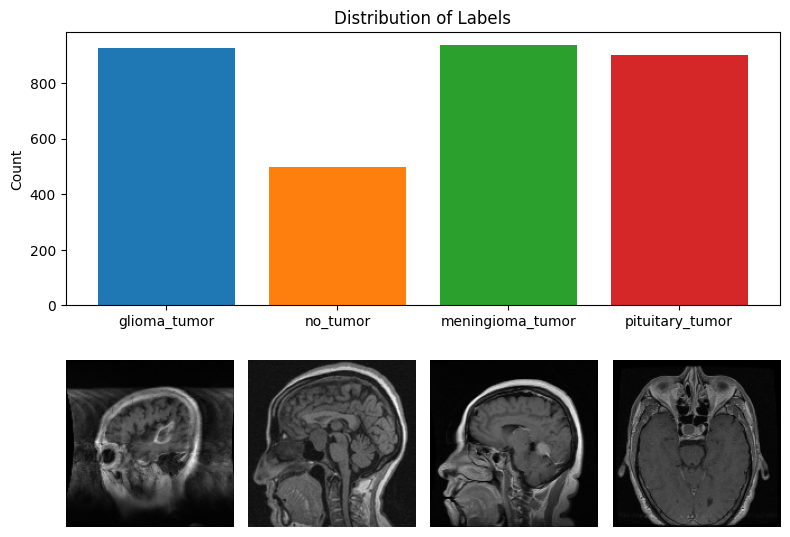

In [7]:
import matplotlib.pyplot as plt

label_counts = {label: np.sum(y_train == label) for label in labels}
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)
# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5)
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1

plt.tight_layout()
plt.show()

In [8]:
image_size = (150, 150)
batch_size = 32

def load_images(df, image_size):
    images = []
    labels = []
    for index, row in df.iterrows():
        img = Image.open(row['image_path']).convert('RGB')
        img = img.resize(image_size)
        img_array = np.array(img)
        images.append(img_array)
        labels.append(row['label'])
    return np.array(images), np.array(labels)


# oversample the dataset
def oversample_dataset(X, y, target_count):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_X = []
    augmented_y = []

    for label in np.unique(y, axis=0):
        label_indices = [i for i, l in enumerate(y) if np.array_equal(l, label)]
        X_label = X[label_indices]
        y_label = y[label_indices]
        count = len(label_indices)

        augmented_X.extend(X_label)
        augmented_y.extend(y_label)

        if count < target_count:
            samples_to_generate = target_count - count
            gen = datagen.flow(X_label, y_label, batch_size=1)
            for _ in range(samples_to_generate):
                img, lbl = next(gen)
                augmented_X.append(img[0])
                augmented_y.append(lbl[0])

    return np.array(augmented_X), np.array(augmented_y)

X_train, y_train = load_images(train_data, image_size)
X_test, y_test = load_images(test_data, image_size)

X_train = X_train / 255.0
X_test = X_test / 255.0

lb = LabelBinarizer()
y_train_categorical = lb.fit_transform(y_train)
y_test_categorical = lb.transform(y_test)

label_counts = Counter(y_train)
target_count = max(label_counts.values())

X_train, y_train_categorical = oversample_dataset(X_train, y_train_categorical, target_count)
#X_test, y_test_categorical = oversample_dataset(X_test, y_test_categorical, target_count)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test_categorical.shape}")


Training data shape: (2684, 150, 150, 3)
Training labels shape: (2684, 4)
Testing data shape: (574, 150, 150, 3)
Testing labels shape: (574, 4)


In [9]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1536, activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
history = model.fit(datagen.flow(X_train, y_train_categorical, batch_size=batch_size),
                    validation_data=(X_test, y_test_categorical),
                    epochs=50)

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1536)              3147264   
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 6148      
                                                                 
Total params: 24956196 (95.20 MB)
Trainable params: 24921

In [10]:
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test accuracy: {accuracy * 100:.2f}%") 

18/18 [==============================] - 1s 33ms/step - loss: 0.1978 - accuracy: 0.9443
Test accuracy: 94.43%


In [13]:
model.save("brain-tumor-incep.h5")